In [1]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz


from util import load_model

In [27]:
model = load_model("deepcluster_exp/linear_classif/with_tracer/checkpoint.pth.tar") # tracer model
# model = load_model("exp1/checkpoint.pth.tar") # pretrained model
model = model.eval()

=> loading checkpoint 'deepcluster_exp/linear_classif/with_tracer/checkpoint.pth.tar'
Loaded


In [28]:
# !wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [29]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [33]:
# transform = transforms.Compose([
#  transforms.Resize(256),
#  transforms.CenterCrop(224),
#  transforms.ToTensor()
# ])

# transform_normalize = transforms.Normalize(
#      mean=[0.485, 0.456, 0.406],
#      std=[0.229, 0.224, 0.225]
#  )

transform_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

transform = transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transform_normalize])




img = Image.open('/home/nova/Lab_individual_works/Daniyal/thesis/Data/ILSVRC_TRAIN/n01855672/n01855672_10519.JPEG')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

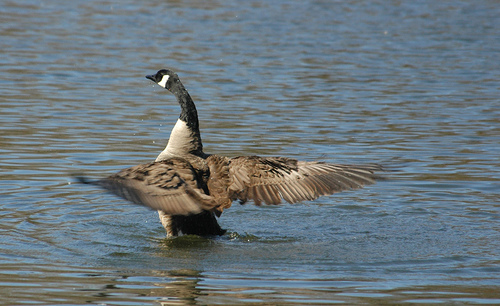

In [34]:
img

In [35]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: trilobite ( 0.9619920253753662 )


In [36]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)





Predicted: trilobite ( 0.9619920253753662 )


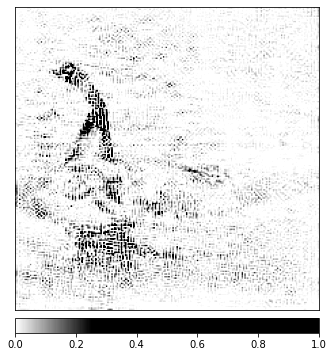

In [37]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


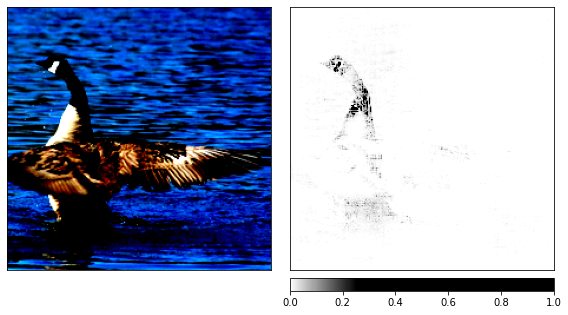

In [38]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


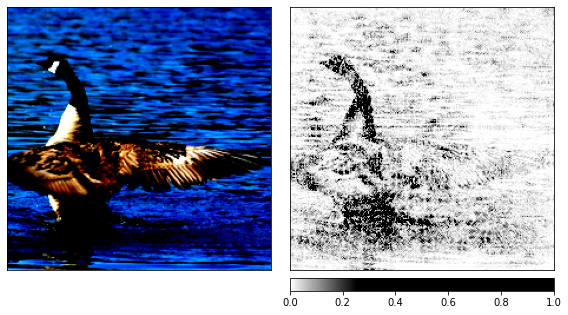

In [39]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


In [40]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


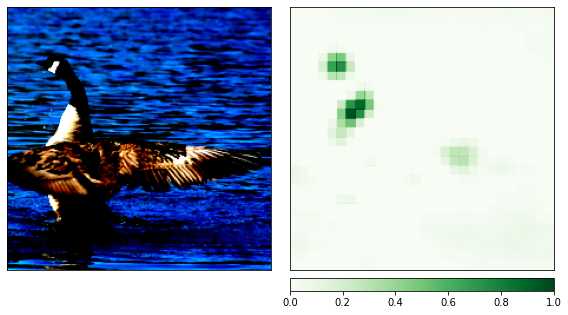

In [41]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


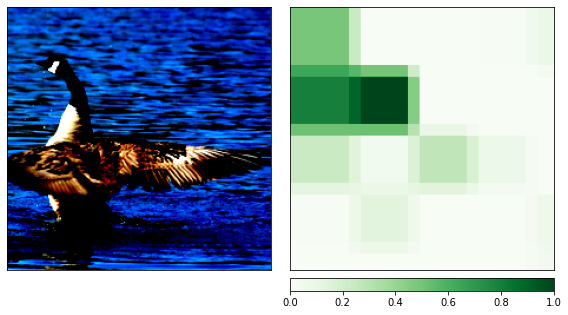

In [42]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )